# Downloading data cubes from the Web Map Service

With the help of requests this script allows the user to download whole timeseries of data (Sentinel 1, 2 and 3) for a certain longitude/latitude combination.

In [1]:
import requests
import json
from PIL import Image
import io
import numpy as np
from urllib.parse import urlsplit, parse_qs
from pprint import pprint
from time import time
from pyproj import Proj, transform

First, the user has to specify the desired lon/lat as well as number of pixels per dimension and the resolution of the image.

In [2]:
# specify central lon/lat of the image as well as dimension
lon = 23.32
lat = 24.16
xdim = 1920 # number of pixels per dimension
ydim = 1080 
reso = 20 # meters

Following now are some cells to specify different parameters, such as Satellite of interest, layer (e.g. true color, NDVI etc.) and maximum cloud cover (called maxcc, if commented out, the max cloud cover will be ignored in the request). The data will be downloaded from the WMS from Sinergise. The data is stored on the Earth Observation Innovative Platform Testbed Poland (EO IPT Poland, www.cloudferro.com/en/eocloud/). The WMS instance has to be configurated (i.e. the user's ID is requested) by the user beforehand for which an account is required (www.sinergise.com).

In [5]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
xC,yC = transform(inProj,outProj, lon, lat)
xmin = xC - xdim*reso/2
xmax = xC + xdim*reso/2
ymin = yC - ydim*reso/2
ymax = yC + ydim*reso/2

ID = 'your ID'
URL = 'http://services.sentinel-hub.com/ogc/wms/'+ID

params = {'service': 'WMS',
          'request': 'GetMap',
          'layers': 'AGRICULTURE',
          'styles': '',
          'format': 'image/png',
          'transparent': 'false',
          'version': '1.1.1',
          'showlogo': 'false',
          'height': ydim,
          'width': xdim,
          'maxcc': 10,
          #'time': '2017-10-12',
          'srs': 'EPSG%3A3857', 
          'bbox': str(xmin)+', '+str(ymin)+', '+str(xmax)+', '+str(ymax)
         }

check if the covered area or the chosen layer etc. are satisfactory

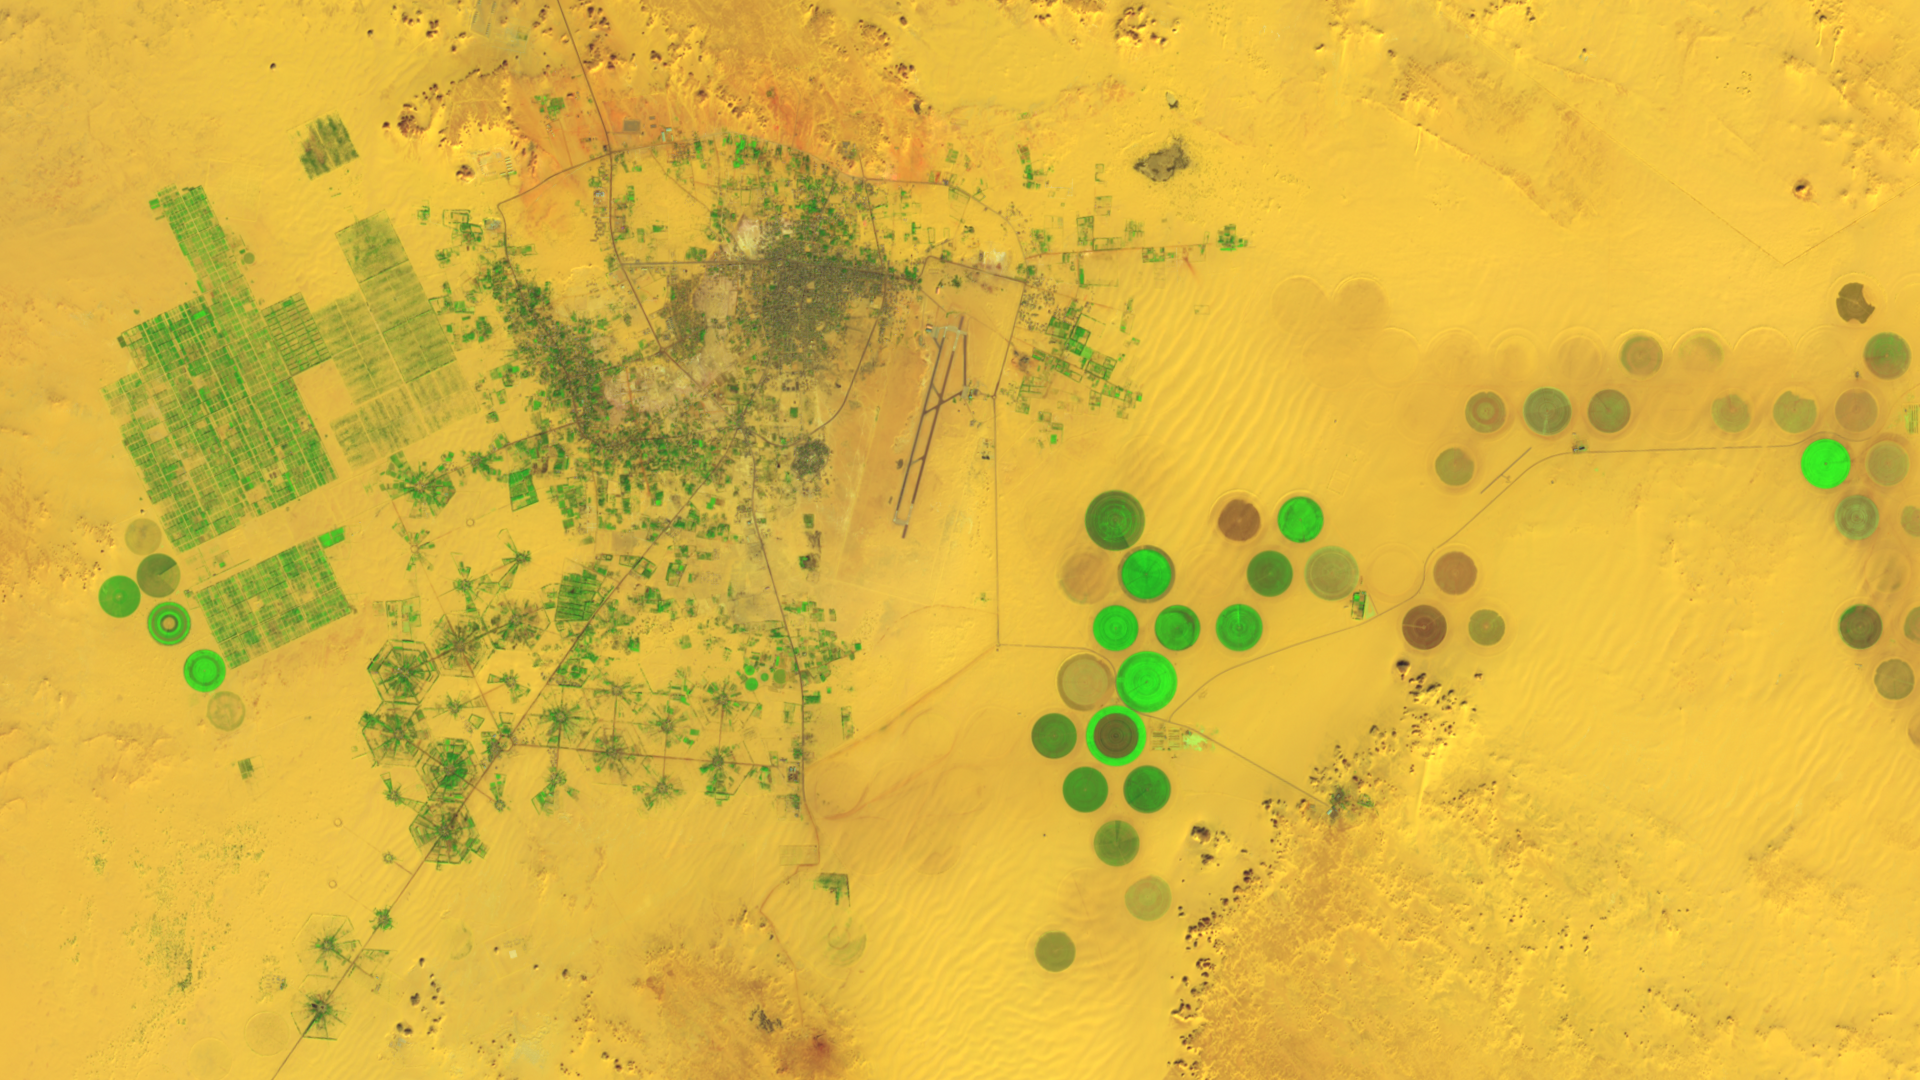

In [6]:
r = requests.get(URL, {**params})
imgTiff = None
try:
    imgTiff = Image.open(io.BytesIO(r.content))
except:
    print(r.url)
imgTiff

with the EO Data Finder check for available dates. Parameters such as 'processingLevel' depend on the chosen satellite and can be looked up here: https://finder.eocloud.eu/www/

In [7]:
EOCURL = 'https://finder.eocloud.eu/resto/api/collections/Sentinel2/search.json'
params_eocurl = {'dataset': 'ESA-DATASET',
                 'lat': str(lat),
                 'lon': str(lon),
                 'maxRecords': 1000,
                 #'processingLevel': 'LEVEL1B',
                 #'cloudCover': '[0,20]',
                 'sortOrder': 'descending',
                 'sortParam': 'startDate'
                }

In [8]:
r1 = requests.get(EOCURL, params_eocurl)
#print(r1.url)
js = json.loads(r1.content)
try:
    num_features = len(js['features'])
    print(f'# products: {num_features}')
except:
    print(r1.url)
    print('Cannot read response')

# products: 108


In [20]:
products = []
dummy = None
for j in js['features']:
    day = j['properties']['startDate'].split('T')[0]
    products.append((day, j))

the actual download:

In [22]:
res = []
starttime = time()
fail = 0
for i, (day, j) in enumerate(products):
    print(f'{i}/{len(products)} loading', end='\r')
    r = requests.get(URL, {**params, **{'time': f'{day}/{day}'}})

    try:
        res.append((day, np.array(Image.open(io.BytesIO(r.content)))))
        print(f'{i}/{len(products)} success')
    except Exception as e:
        print(f'{i}/{len(products)} failure')
        fail += fail
        
        #print(r.url)
endtime = time()
duration = (endtime - starttime)/60
print(f'{duration} minutes,', f'{fail} failed')

0/107 success
1/107 success
2/107 success
3/107 success
4/107 success
5/107 success
6/107 success
7/107 success
8/107 success
9/107 success
10/107 success
11/107 success
12/107 success
13/107 success
14/107 success
15/107 success
16/107 success
17/107 success
18/107 success
19/107 success
20/107 success
21/107 success
22/107 success
23/107 success
24/107 success
25/107 success
26/107 success
27/107 success
28/107 success
29/107 failure
30/107 success
31/107 success
32/107 success
33/107 success
34/107 success
35/107 success
36/107 success
37/107 success
38/107 success
39/107 success
40/107 success
41/107 success
42/107 success
43/107 success
44/107 success
45/107 success
46/107 success
47/107 success
48/107 success
49/107 success
50/107 success
51/107 success
52/107 success
53/107 success
54/107 success
55/107 success
56/107 success
57/107 success
58/107 success
59/107 success
60/107 success
61/107 success
62/107 success
63/107 success
64/107 success
65/107 success
66/107 success
67/10

# saving section

used to save all the downloaded data for further use. The file's default name (may be changed) consists of 4 things: Name (has to be given by the user, e.g. name of the scene), layer, lon and lat.

In [23]:
ts1 = []
if lon <= 0:
    lonS = str(lon+360)+'E'
else:
    lonS = str(lon)+'E'
if lat <= 0:
    latS = str(-lat)+'S'
else:
    latS = str(lat)+'N'
    
for i in range(len(res)):
    ts1.append(res[i][1])
layer = params['layers']
name = 'S2_ALJAWF'
np.save(f'Data/{name}_{layer}_{lonS}_{latS}', np.array(ts1))

In [24]:
ts2 = []
for i in range(len(res)):
    ts2.append(res[i][0])
np.save(f'Data/{name}_{layer}_{lonS}_{latS}_days', np.array(ts2))